In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from undistort import get_undistorter
from test import process_frame

In [ ]:
ud = get_undistorter()

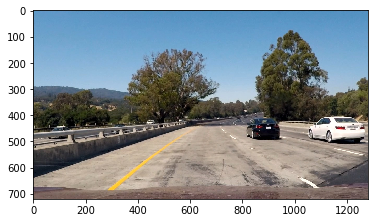

In [22]:


image = mpimg.imread("test_images/test1.jpg")
plt.imshow(image)

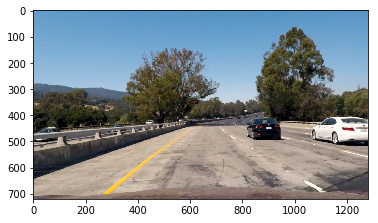

In [4]:
image_ud = ud(image)
plt.imshow(image_ud)

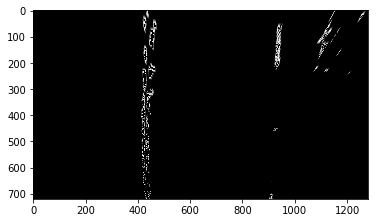

In [5]:
p_image = process_frame(image, True)
plt.imshow(p_image)

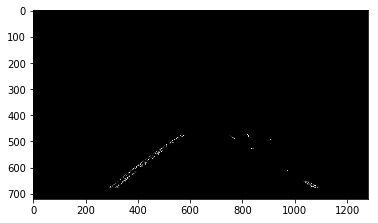

In [7]:
from test import pers_transform
p_image_nat = pers_transform(p_image, True)
plt.imshow(p_image_nat)

In [19]:
image = cv2.line(image, (254, 677), (561, 474), (255, 0, 0), 2)
image = cv2.line(image, (725, 474), (1040, 677), (255, 0, 0), 2)

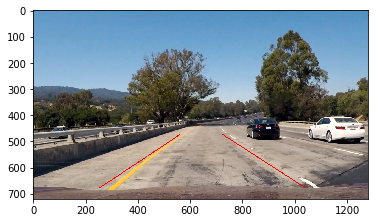

In [20]:
plt.imshow(image)

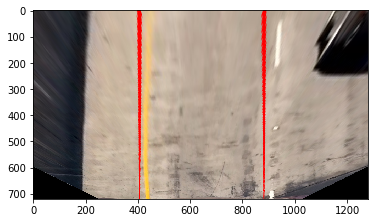

In [21]:
image_t = pers_transform(image)
plt.imshow(image_t)

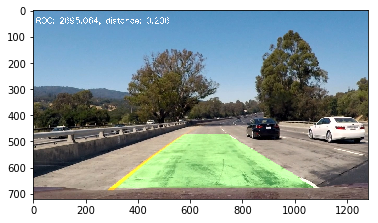

In [23]:
lane_lines = process_frame(image)
plt.imshow(lane_lines)

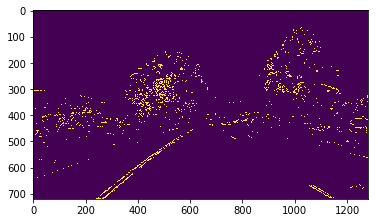

In [25]:
from test import *